In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec as gs
%matplotlib inline
plt.style.use('bmh')
from scipy import stats as ss
import seaborn as sns
sns.set_style('dark')
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

In [2]:
n = 500 # number of students
def grades(lower, upper, mean, std, n=n): # get an array of grades in a range and distribution parameters
    return [int(x) for x in (ss.truncnorm.rvs(((lower - mean) / std), ((upper - mean) / std), loc=mean, scale=std, size=n))]

### Gathering grades
#### Labs

In [3]:
Lab = dict()
for _ in range(1, 9):
    Lab[_] = grades(0, 10, 5, 5)
for key, item in Lab.items():
    print(f"Lab {key} -> {item[:10]}")

Lab 1 -> [4, 5, 7, 5, 3, 2, 7, 7, 5, 6]
Lab 2 -> [0, 1, 7, 5, 3, 0, 7, 9, 1, 1]
Lab 3 -> [1, 8, 8, 9, 7, 1, 5, 8, 0, 1]
Lab 4 -> [6, 3, 1, 6, 5, 7, 3, 7, 8, 4]
Lab 5 -> [6, 4, 1, 7, 0, 6, 1, 5, 9, 0]
Lab 6 -> [0, 6, 8, 7, 2, 9, 7, 7, 5, 6]
Lab 7 -> [8, 4, 5, 9, 6, 7, 1, 3, 3, 9]
Lab 8 -> [4, 8, 9, 9, 5, 2, 3, 5, 8, 5]


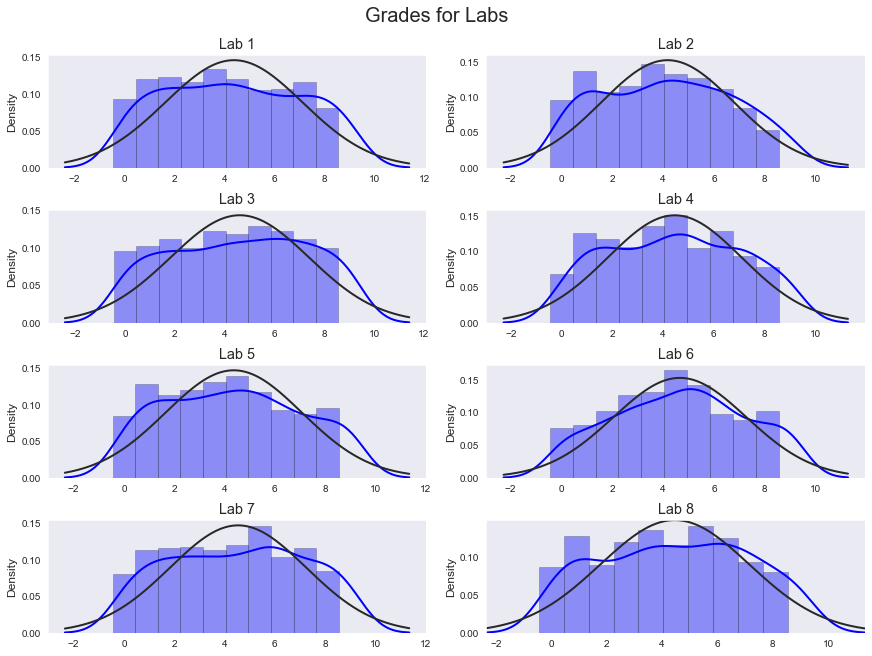

In [4]:
fig = plt.figure(constrained_layout=True, figsize=(12, 9))
grid = gs(nrows=4, ncols=2, figure=fig)
for _ in range(8):
    ax = fig.add_subplot(grid[_])
    # comparing distribution of grades to a regular normal distribution line
    sns.distplot(Lab[(_+1)], fit=ss.norm, ax=ax, norm_hist=True, color='blue', 
                 hist_kws=dict(edgecolor='black', align='left', color='blue'), bins=10)
    ax.set_title(f"Lab {_+1}")
fig.suptitle('Grades for Labs', fontsize=20)
plt.margins(0.001, 0.001)
grid.tight_layout(fig)
plt.show()

#### Assignments 

In [5]:
Assignment = dict()
for _ in range(1, 5):
    Assignment[_] = grades(0, 10, 5, 4)
for key, item in Assignment.items():
    print(f"Assignment {key} -> {item[:10]}")

Assignment 1 -> [4, 6, 2, 6, 0, 4, 7, 9, 2, 5]
Assignment 2 -> [3, 6, 7, 4, 3, 5, 9, 8, 5, 4]
Assignment 3 -> [0, 4, 2, 4, 7, 5, 3, 7, 3, 0]
Assignment 4 -> [6, 5, 7, 1, 4, 8, 7, 4, 5, 4]


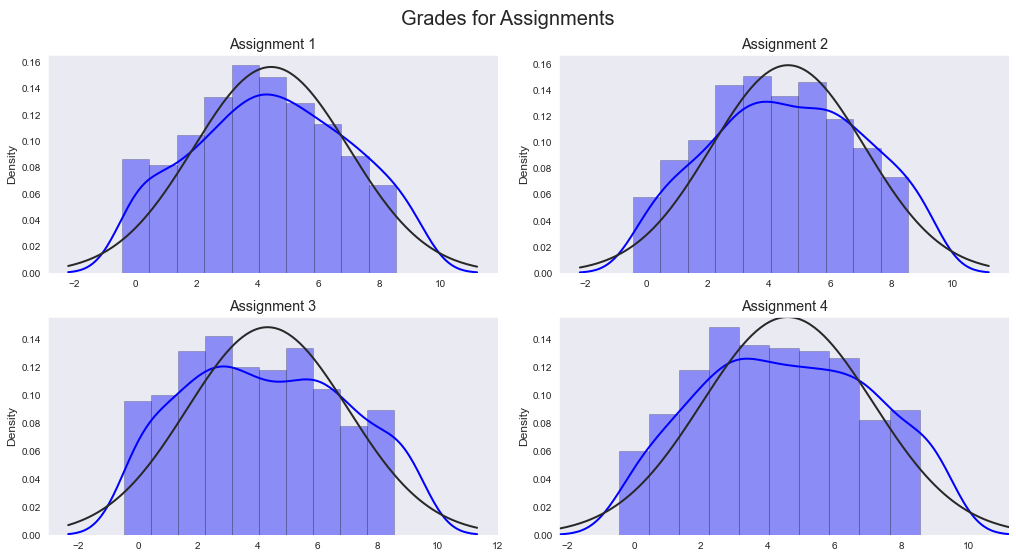

In [6]:
fig = plt.figure(constrained_layout=True, figsize=(14, 14))
grid = gs(nrows=4, ncols=2, figure=fig)
for _ in range(4):
    ax = fig.add_subplot(grid[_])
    # comparing distribution of grades to a regular normal distribution line
    sns.distplot(Assignment[(_+1)], fit=ss.norm, ax=ax, norm_hist=True, color='blue', 
                 hist_kws=dict(edgecolor='black', align='left', color='blue'), bins=10)
    ax.set_title(f"Assignment {_+1}")
fig.suptitle('Grades for Assignments', fontsize=20)
plt.margins(0.001, 0.001)
grid.tight_layout(fig)
plt.show()

#### Mid-Terms 

In [7]:
Mid_term = dict()
for _ in range(1, 3):
    Mid_term[_] = grades(0, 100, 50, 7)
for key, item in Mid_term.items():
    print(f"Mid-Term {key} -> {item[:10]}")

Mid-Term 1 -> [41, 51, 44, 52, 48, 47, 52, 53, 37, 51]
Mid-Term 2 -> [52, 62, 43, 61, 56, 44, 49, 53, 49, 52]


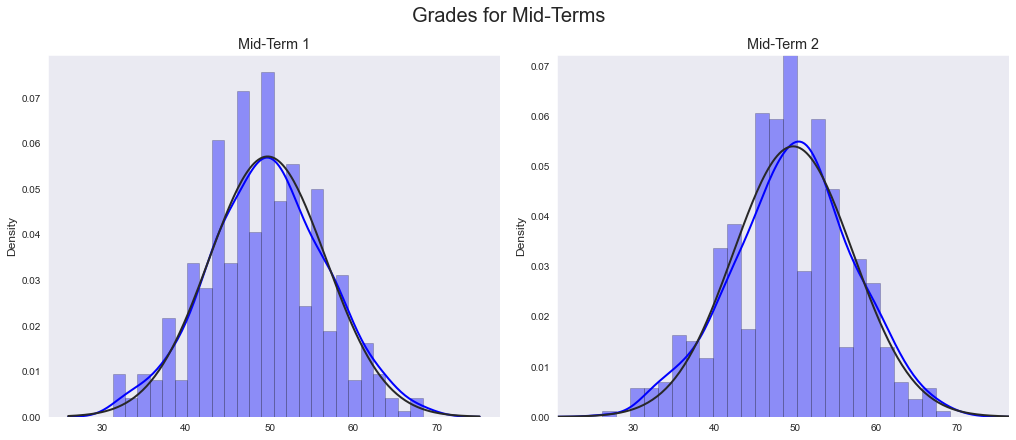

In [8]:
fig = plt.figure(constrained_layout=True, figsize=(14, 6))
grid = gs(nrows=1, ncols=2, figure=fig)
for _ in range(2):
    ax = fig.add_subplot(grid[_])
    # comparing distribution of grades to a regular normal distribution line
    sns.distplot(Mid_term[(_+1)], fit=ss.norm, ax=ax, norm_hist=True, color='blue', 
                 hist_kws=dict(edgecolor='black', align='left', color='blue'), bins=25)
    ax.set_title(f"Mid-Term {_+1}")
fig.suptitle('Grades for Mid-Terms', fontsize=20)
plt.margins(0.001, 0.001)
grid.tight_layout(fig)
plt.show()

#### Final Exam

In [9]:
Final = grades(0, 100, 65, 9)
print(f"Final Exam -> {Final[:10]}")

Final Exam -> [75, 53, 66, 69, 62, 56, 53, 66, 65, 76]


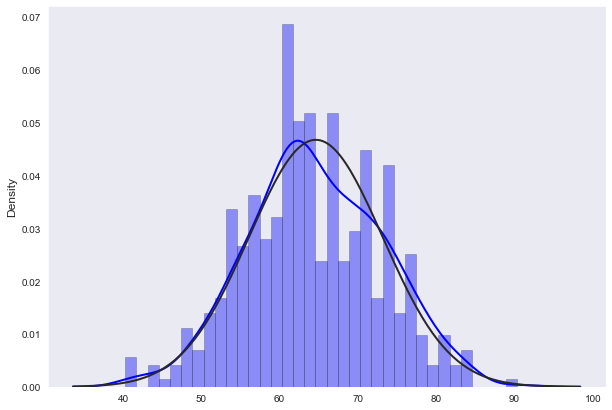

In [10]:
plt.figure(figsize=(10, 7))
sns.distplot(Final, fit=ss.norm, norm_hist=True, color='blue', 
             hist_kws=dict(edgecolor='black', align='left', color='blue'), bins=35)
plt.show()

### Grade Weights 
Each type of test will contribute this much to the final grade:
* Final Exam = 30%
* Mid-Terms = 30%
* Assignments = 20%
* Labs = 20%

Total passing percentage is assumed to be **60%**

### Making the DataFrame 
#### Combining the marks togethe

In [11]:
df = pd.DataFrame(index=range(1, n+1))
df.index.name = 'Student'

# automate the process of inputting the grades for all tests for each student
for _ in range(1, 9):
    df[f"Lab {_}"] = Lab[_]

for _ in range(1, 5):
    df[f"Assignment {_}"] = Assignment[_]
    
for _ in range(1, 3):
    df[f"Mid-Term {_}"] = Mid_term[_]
    
df['Final'] = Final
    
df.head()

,Lab 1,Lab 2,Lab 3,Lab 4,Lab 5,Lab 6,Lab 7,Lab 8,Assignment 1,Assignment 2,Assignment 3,Assignment 4,Mid-Term 1,Mid-Term 2,Final
Student,,,,,,,,,,,,,,,
1,4,0,1,6,6,0,8,4,4,3,0,6,41,52,75
2,5,1,8,3,4,6,4,8,6,6,4,5,51,62,53
3,7,7,8,1,1,8,5,9,2,7,2,7,44,43,66
4,5,5,9,6,7,7,9,9,6,4,4,1,52,61,69
5,3,3,7,5,0,2,6,5,0,3,7,4,48,56,62


In [12]:
print(f"No. of students -> {len(df)}\nNumber of tests -> {df.shape[1]}")

No. of students -> 500
Number of tests -> 15


#### Determining if a student passes

In [13]:
Final_percent = 0.3
Mid_term_percent = 0.3
Assignments_percent = 0.2
Labs_percent = 0.2

Calculate the total grade for each category of test, then use that total and calculate the overall percentage of how much it contributes to students (based on the test's weightage) **overall** grade

In [14]:
lab_grades = list(df.iloc[:, :8].apply(lambda x: np.sum(x) / 80, axis=1) * Labs_percent)
assignment_grades = list(df.iloc[:, 8:12].apply(lambda x: np.sum(x) / 40, axis=1) * Assignments_percent)
mid_term_grades = list(df.iloc[:, 12:14].apply(lambda x: np.sum(x) / 200, axis=1) * Mid_term_percent)
final_grades = list(df.Final.apply(lambda x: (x / 100) * Final_percent))
lab_grades[:10]

[0.0725,
 0.0975,
 0.11499999999999999,
 0.14250000000000002,
 0.07750000000000001,
 0.085,
 0.085,
 0.1275,
 0.0975,
 0.08000000000000002]

In [15]:
overall_grades = [] # calculate the total grade percentage
for _ in range(n):
    overall_grades.append(np.round((lab_grades[_] + assignment_grades[_] + mid_term_grades[_] + final_grades[_]) * 100, 2))
overall_grades[:10]

[50.2, 53.1, 53.35, 59.4, 48.95, 49.95, 52.55, 62.45, 49.65, 52.75]

#### Finishing the final table 

In [16]:
df['Total'] = overall_grades
df['Pass/Fail'] = ["Pass" if x >= 50 else "Fail" for x in overall_grades]
df.head()

,Lab 1,Lab 2,Lab 3,Lab 4,Lab 5,Lab 6,Lab 7,Lab 8,Assignment 1,Assignment 2,Assignment 3,Assignment 4,Mid-Term 1,Mid-Term 2,Final,Total,Pass/Fail
Student,,,,,,,,,,,,,,,,,
1,4,0,1,6,6,0,8,4,4,3,0,6,41,52,75,50.20,Pass
2,5,1,8,3,4,6,4,8,6,6,4,5,51,62,53,53.10,Pass
3,7,7,8,1,1,8,5,9,2,7,2,7,44,43,66,53.35,Pass
4,5,5,9,6,7,7,9,9,6,4,4,1,52,61,69,59.40,Pass
5,3,3,7,5,0,2,6,5,0,3,7,4,48,56,62,48.95,Fail


In [17]:
df.describe().drop(['count', '25%', '50%', '75%'])

,Lab 1,Lab 2,Lab 3,Lab 4,Lab 5,Lab 6,Lab 7,Lab 8,Assignment 1,Assignment 2,Assignment 3,Assignment 4,Mid-Term 1,Mid-Term 2,Final,Total
mean,4.376000,4.180000,4.608000,4.460000,4.368000,4.662000,4.542000,4.46600,4.45000,4.622000,4.330000,4.598000,49.752000,49.766000,64.622000,52.229800
std,2.746947,2.617882,2.783853,2.643933,2.712802,2.612548,2.712739,2.69432,2.55275,2.507527,2.691391,2.565455,6.988288,7.407089,8.541489,4.343135
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,32.000000,27.000000,41.000000,37.450000
max,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.00000,9.00000,9.000000,9.000000,9.000000,69.000000,70.000000,91.000000,66.750000


### Creating excel file 

In [18]:
df.to_excel("Grades.xlsx", sheet_name='Grades')

### Making the Classifier 
#### Preprocessing

In [19]:
df_cf = df.copy()
df_cf.head()

,Lab 1,Lab 2,Lab 3,Lab 4,Lab 5,Lab 6,Lab 7,Lab 8,Assignment 1,Assignment 2,Assignment 3,Assignment 4,Mid-Term 1,Mid-Term 2,Final,Total,Pass/Fail
Student,,,,,,,,,,,,,,,,,
1,4,0,1,6,6,0,8,4,4,3,0,6,41,52,75,50.20,Pass
2,5,1,8,3,4,6,4,8,6,6,4,5,51,62,53,53.10,Pass
3,7,7,8,1,1,8,5,9,2,7,2,7,44,43,66,53.35,Pass
4,5,5,9,6,7,7,9,9,6,4,4,1,52,61,69,59.40,Pass
5,3,3,7,5,0,2,6,5,0,3,7,4,48,56,62,48.95,Fail


In [20]:
df_cf_y = LabelEncoder().fit_transform(df_cf['Pass/Fail'])
df_cf.drop(['Final', 'Total', 'Pass/Fail'], axis=1, inplace=True)
df_cf_x = StandardScaler().fit_transform(df_cf)
df_cf_x[0]

array([-0.13701634, -1.59830968, -1.29734359,  0.58304897,  0.60219451,
       -1.786252  ,  1.27600295, -0.17312963, -0.17645702, -0.6475003 ,
       -1.61044457,  0.54703908, -1.2536354 ,  0.301905  ])

In [21]:
df_cf_x_train, df_cf_x_test, df_cf_y_train, df_cf_y_test = train_test_split(df_cf_x, df_cf_y, stratify=df_cf_y, 
                                                                           test_size=.15, random_state=7)
print(f"Train X -> {df_cf_x_train.shape}\nTrain y -> {df_cf_y_train.shape}")
print(f"Test X -> {df_cf_x_test.shape}\nTest y -> {df_cf_y_test.shape}")

Train X -> (425, 14)
Train y -> (425,)
Test X -> (75, 14)
Test y -> (75,)


#### Setting up the models
##### RandomForestClassifier

In [22]:
rfc = RandomizedSearchCV(estimator=RandomForestClassifier(),
                  param_distributions={'n_estimators':range(100, 1050, 100), 
                                       'warm_start':[True], 'criterion':['gini', 'entropy']},
                  n_jobs=-1, cv=RepeatedStratifiedKFold(random_state=7), 
                  return_train_score=True, verbose=3, n_iter=100, refit=True)
rfc.fit(df_cf_x_train, df_cf_y_train)
rfc.best_params_

Fitting 50 folds for each of 20 candidates, totalling 1000 fits


{'warm_start': True, 'n_estimators': 500, 'criterion': 'entropy'}

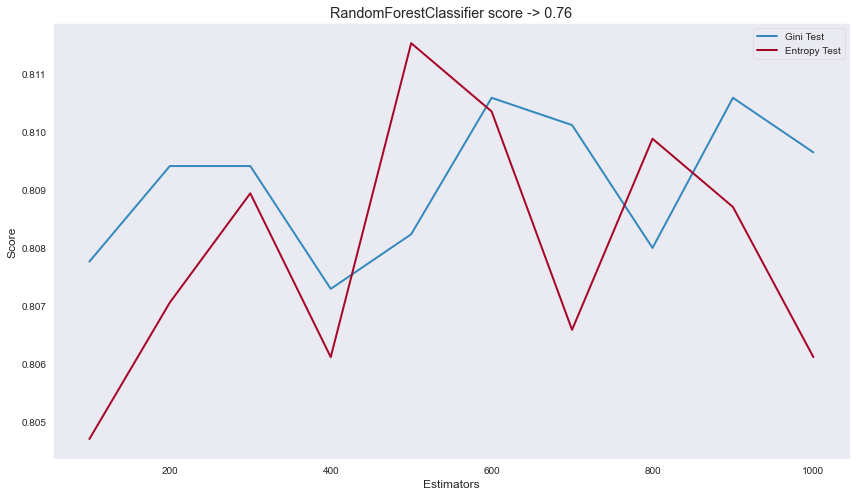

In [23]:
plt.figure(figsize=(12, 7))
plt.title(f"RandomForestClassifier score -> {rfc.score(df_cf_x_test, df_cf_y_test)}")
plt.plot(range(100, 1050, 100), 
         pd.DataFrame(rfc.cv_results_)['mean_test_score'][pd.DataFrame(rfc.cv_results_)['param_criterion'] == 'gini'], 
         label='Gini Test')
plt.plot(range(100, 1050, 100), 
         pd.DataFrame(rfc.cv_results_)['mean_test_score'][pd.DataFrame(rfc.cv_results_)['param_criterion'] == 'entropy'], 
         label='Entropy Test')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.legend()
plt.tight_layout()
plt.show()

##### LogisticRegressionCV 

In [24]:
logreg = LogisticRegressionCV(cv=RepeatedStratifiedKFold(n_splits=10, random_state=7), 
                             max_iter=1000, n_jobs=-1, verbose=3, refit=True, random_state=7).fit(df_cf_x_train, 
                                                                                                  df_cf_y_train)
logreg.score(df_cf_x_test, df_cf_y_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.8s finished


0.7733333333333333

##### KNeighborsClassifier

In [25]:
knn = RandomizedSearchCV(estimator=KNeighborsClassifier(), param_distributions={'n_neighbors':range(1, 16), 
                                                                'weights':['uniform', 'distance'], 
                                                                'n_jobs':[-1]}, 
                  cv=RepeatedStratifiedKFold(random_state=7), n_jobs=-1, return_train_score=True, 
                         verbose=3, refit=True, n_iter=100)
knn.fit(df_cf_x_train, df_cf_y_train)
knn.best_params_

Fitting 50 folds for each of 30 candidates, totalling 1500 fits


{'weights': 'uniform', 'n_neighbors': 14, 'n_jobs': -1}

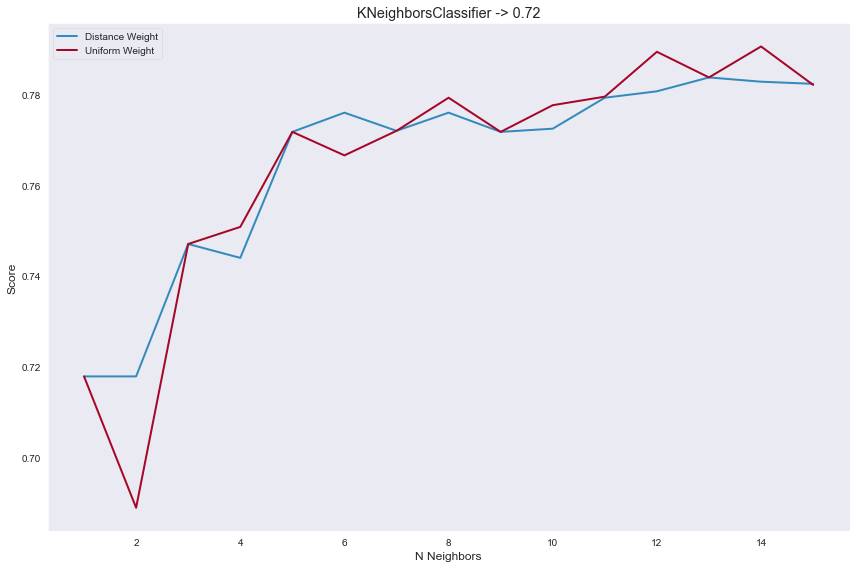

In [26]:
plt.figure(figsize=(12, 8))
plt.plot(range(1, 16), pd.DataFrame(knn.cv_results_)['mean_test_score'][pd.DataFrame(knn.cv_results_)['param_weights'] == 'distance'],
        label='Distance Weight')
plt.plot(range(1, 16), pd.DataFrame(knn.cv_results_)['mean_test_score'][pd.DataFrame(knn.cv_results_)['param_weights'] == 'uniform'], 
        label='Uniform Weight')
plt.title(f"KNeighborsClassifier -> {knn.score(df_cf_x_test, df_cf_y_test)}")
plt.xlabel('N Neighbors')
plt.ylabel('Score')
plt.legend()
plt.tight_layout()
plt.show()

##### Naive-Bayes Classifier 

In [27]:
gnb = GaussianNB().partial_fit(df_cf_x_train, df_cf_y_train, np.unique(df_cf_y_train))
gnb.score(df_cf_x_test, df_cf_y_test)

0.7466666666666667

##### Decision Tree Classifier

In [28]:
dtc = DecisionTreeClassifier(criterion='entropy').fit(df_cf_x_train, df_cf_y_train)
dtc.score(df_cf_x_test, df_cf_y_test)

0.68

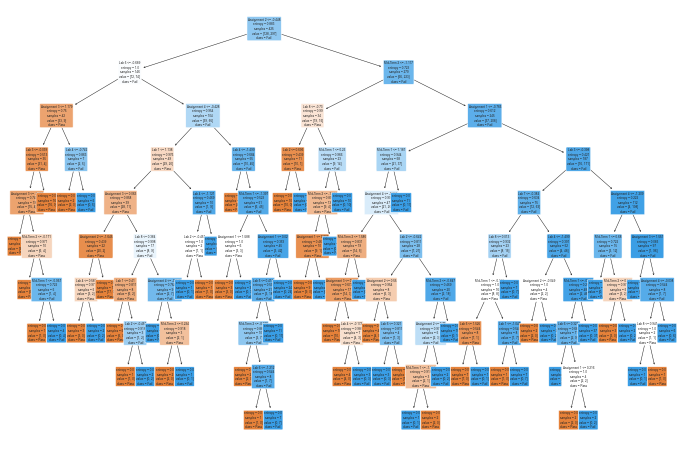

In [29]:
fig = plt.figure(figsize=(12, 8))
dtc_tree = tree.plot_tree(dtc, feature_names=df_cf.columns, class_names=['Pass', 'Fail'], filled=True, rounded=True,
                         fontsize=3)

##### Gradient Boosting Classifier

In [30]:
gbc = RandomizedSearchCV(estimator=GradientBoostingClassifier(), 
                         param_distributions={'learning_rate':np.arange(0.1, 1.1, 0.1),
                                              'n_estimators':range(100, 1050, 50),
                                              'warm_start':[True], 'random_state':[7], 'verbose':[2]},
                  n_jobs=-1, verbose=3, return_train_score=True, cv=RepeatedStratifiedKFold(random_state=7),
                        refit=True, n_iter=100)
gbc.fit(df_cf_x_train, df_cf_y_train)

Fitting 50 folds for each of 100 candidates, totalling 5000 fits
      Iter       Train Loss   Remaining Time 
         1           1.0537            0.10s
         2           0.9520            0.10s
         3           0.8614            0.10s
         4           0.8103            0.10s
         5           0.7664            0.10s
         6           0.7205            0.11s
         7           0.6699            0.11s
         8           0.6268            0.10s
         9           0.5915            0.10s
        10           0.5555            0.10s
        11           0.5192            0.10s
        12           0.4863            0.10s
        13           0.4600            0.09s
        14           0.4348            0.09s
        15           0.4157            0.09s
        16           0.4013            0.09s
        17           0.3797            0.09s
        18           0.3632            0.09s
        19           0.3480            0.09s
        20           0.3337       

RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=7),
                   estimator=GradientBoostingClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                                        'n_estimators': range(100, 1050, 50),
                                        'random_state': [7], 'verbose': [2],
                                        'warm_start': [True]},
                   return_train_score=True, verbose=3)

In [31]:
gbc.best_params_

{'warm_start': True,
 'verbose': 2,
 'random_state': 7,
 'n_estimators': 100,
 'learning_rate': 0.30000000000000004}

In [32]:
gbc.score(df_cf_x_test, df_cf_y_test)

0.7866666666666666

####  Evaluating models

In [33]:
models = pd.DataFrame(index=['RandomForestClassifier', 'LogisticRegressionCV', 'KNeighborsClassifier', 
                      'GaussianNB', 'DecisionTreeClassifier', 'GradientBoosting'])
models.index.name="Algorithms"
models['Score'] = [rfc.score(df_cf_x_test, df_cf_y_test), logreg.score(df_cf_x_test, df_cf_y_test), 
                  knn.score(df_cf_x_test, df_cf_y_test), gnb.score(df_cf_x_test, df_cf_y_test), 
                  dtc.score(df_cf_x_test, df_cf_y_test), gbc.score(df_cf_x_test, df_cf_y_test)]
models['f1 Score'] = [f1_score(df_cf_y_test, rfc.predict(df_cf_x_test)), 
                      f1_score(df_cf_y_test, logreg.predict(df_cf_x_test)),
                     f1_score(df_cf_y_test, knn.predict(df_cf_x_test)),
                     f1_score(df_cf_y_test, gnb.predict(df_cf_x_test)),
                     f1_score(df_cf_y_test, dtc.predict(df_cf_x_test)),
                     f1_score(df_cf_y_test, gbc.predict(df_cf_x_test))]
models.sort_values(["Score", 'f1 Score'], ascending=False)

,Score,f1 Score
Algorithms,,
GradientBoosting,0.786667,0.849057
LogisticRegressionCV,0.773333,0.849558
RandomForestClassifier,0.760000,0.842105
GaussianNB,0.746667,0.828829
KNeighborsClassifier,0.720000,0.817391
DecisionTreeClassifier,0.680000,0.773585


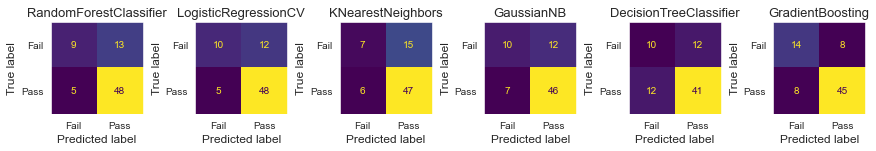

In [34]:
models_list = [rfc, logreg, knn, gnb, dtc, gbc]
model_names = ['RandomForestClassifier', 'LogisticRegressionCV', 'KNearestNeighbors', 'GaussianNB', 
              'DecisionTreeClassifier', 'GradientBoosting']
fig = plt.figure(constrained_layout=True, figsize=(12, 8))
grid = gs(nrows=1, ncols=len(models), figure=fig)
for _ in range(len(models)):
    ax = fig.add_subplot(grid[_])
    plot_confusion_matrix(models_list[_], df_cf_x_test, df_cf_y_test, labels=[0, 1],
                         display_labels=['Fail', 'Pass'], colorbar=False, ax=ax)
    plt.title(f"{model_names[_]}", fontsize=13)
    
plt.show()